In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import skimage.measure

from nionswift_plugin.usim.SampleSimulator import gaussian_superposition

from psm.libraries import load_library
from psm.structures.graphene import build_rectangular_graphene, insert_defect_graphene
from psm.structures.utils import rotate, fill_rectangle
from psm.graph import stable_delaunay_graph

from IPython.display import clear_output

In [3]:
def closest_points(point, other_points):
    return cdist([point], other_points).argmin()

def bandpass_noise(inner, outer, shape):
    kx = np.fft.fftfreq(shape[0], 1 / shape[0])
    ky = np.fft.fftfreq(shape[1], 1 / shape[1])
    k = np.sqrt(kx[:, None] ** 2 + ky[None] ** 2)
    r = np.random.rand(*k.shape).astype(np.float32)
    mask = ((k > inner) & (k < outer)).astype(np.float32)
    noise = np.fft.fftn(mask * np.exp(-1.j * r * 2 * np.pi), axes=tuple(range(len(k.shape))))
    noise = (noise.real + noise.imag) / 2
    return (noise / (np.std(noise) + 1e-6))

In [9]:
library, alias = load_library('graphene')

for defect in library.values():
    if defect.labels is None:
        defect.set_labels(np.zeros(len(defect), np.int))

In [5]:
name = 'test_image.npz'

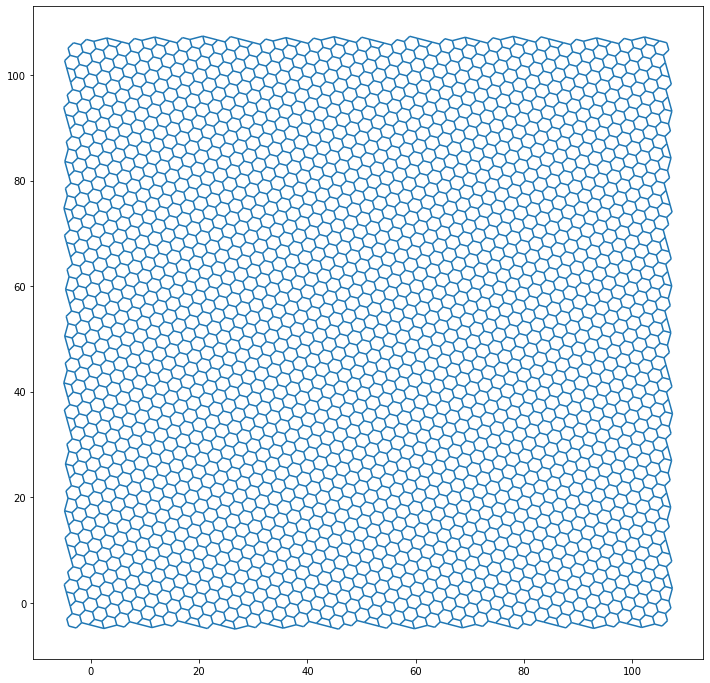

In [30]:
points, cell = build_rectangular_graphene(n=2, m=1)
points, cell = rotate(points, np.random.rand()*360, cell, rotate_cell=True)
points, cell = fill_rectangle(points, cell, (102.4, 102.4), margin=5)

graph = stable_delaunay_graph(points, 2)
graph.set_labels(np.zeros(len(graph), np.int))

fig,ax=plt.subplots(figsize=(12,12))
graph.plot(ax=ax)

In [31]:
target_num_defects = 10 # should fit in the sample, other it will loop infinitely
keys = list(library.keys())

dual = graph.dual()

i = 0
while i < target_num_defects:
    defect_key = keys[np.random.randint(len(keys))]
    defect_graph = library[defect_key]
    defect_position = [np.random.rand() * 30, np.random.rand() * 30]
    seed = closest_points(defect_position, dual.points)
    
    try:
        graph = insert_defect_graphene(graph, defect_graph, seed, np.random.randint(6))
        i += 1
        print('{} defects inserted'.format(i))
        clear_output(wait=True)
    except (RuntimeError, KeyError, ZeroDivisionError): # possible exceptions on overlapping defects
        pass

10 defects inserted


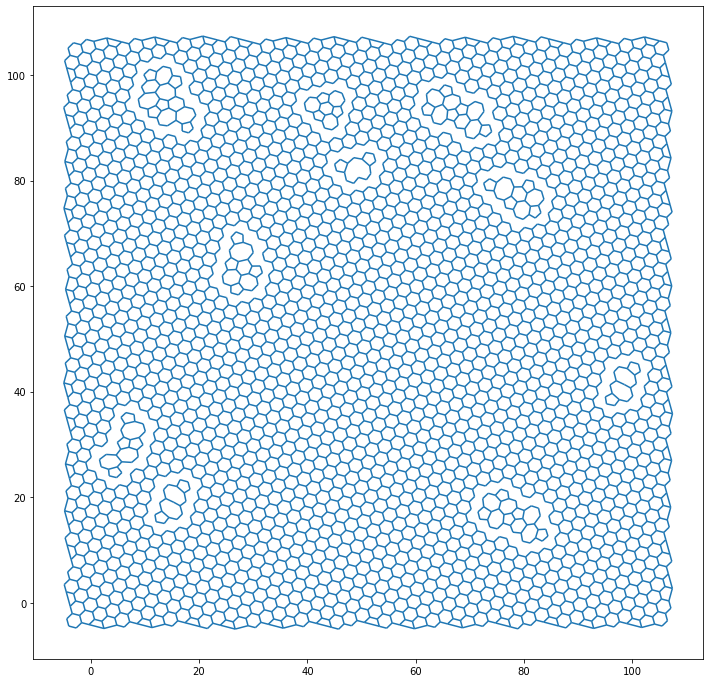

In [32]:
fig,ax=plt.subplots(figsize=(12,12))
graph.plot(ax=ax)

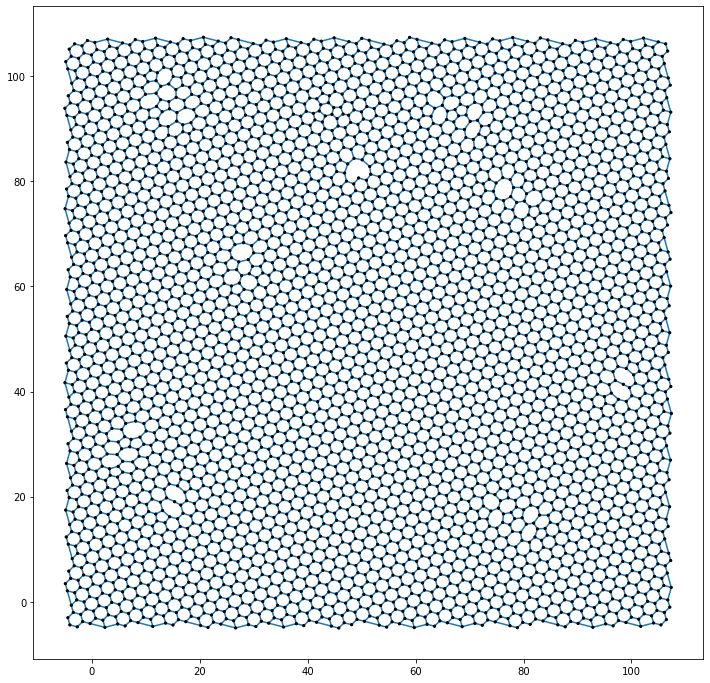

In [33]:
labels = graph.labels
graph = stable_delaunay_graph(graph.points, 2)
graph.set_labels(labels)

fig,ax=plt.subplots(figsize=(12,12))
graph.plot(ax=ax, point_colors={0:'k',1:'red'}, point_kwargs={'s':5})

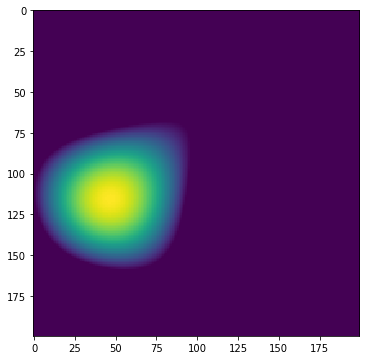

In [54]:
noise = bandpass_noise(0,2,(200,200))
noise -= noise.min()
noise = noise ** .5
contamination = np.zeros_like(noise)
t = 1.7
contamination[noise > t] += noise[noise > t] - t
labelled, n = skimage.measure.label(noise > t, return_num=True)

#for i in np.random.randint(n, size=20):
#    p[labelled == i] = 0

plt.figure(figsize=(6,6))
plt.imshow(contamination)

contamination_points = np.array(np.where(np.random.poisson(contamination))).T / 4
contamination_points = contamination_points.astype(np.float)
contamination_points += np.random.randn(*contamination_points.shape)

In [1756]:
#contamination[rounded[:,0],rounded[:,1]]

In [55]:
from skimage.morphology import dilation, disk

extent = np.array(np.diag(cell))
sampling = .1
gpts = np.ceil(extent / sampling).astype(np.int)

rounded = np.round(graph.points * 4).astype(np.int)
inside = np.where((rounded[:,0]>0)&(rounded[:,1]>0)&(rounded[:,0]<200)&(rounded[:,1]<200))[0]
rounded = rounded[inside]

is_contamination = dilation(contamination > 0, disk(5))

#plt.plot(*rounded.T,'ro')
#print(contamination.shape)

labels = np.zeros(len(graph.points), np.int)
labels[graph.labels == 1] = 2
labels[inside[np.where(is_contamination[rounded[:,0],rounded[:,1]])[0]]] = 1

#points = graph.points
points = np.vstack((graph.points, contamination_points))
labels = np.concatenate((labels, np.full(len(contamination_points), 1, np.int)))

intensities = np.ones(len(points))
intensities[np.where(graph.labels == 1)[0]] = 5
image = gaussian_superposition(points, intensities, extent, .5, gpts)
image = np.random.poisson(image*(1.75 + np.random.rand() * 2) + 5)

In [1758]:
#points = points - points.mean(axis=0)
#np.savez('defect_graphene.npz', points=points, intensities=intensities)

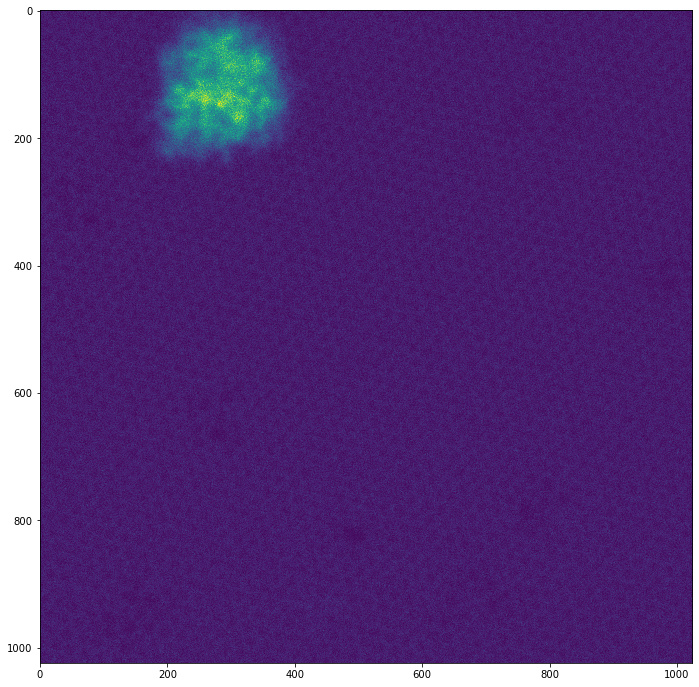

In [58]:
plt.figure(figsize=(12,12))
plt.imshow(image.T)
#plt.figure(figsize=(12,12))
#plt.imshow(is_contamination.T)
#print(image.shape)
np.save('test_image.npy',image)
#plt.scatter(*points.T / sampling, c=labels)
#np.savez(name, image=image, points=points / sampling, sampling=.1, labels=labels)